# Libraries

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Typing
from typing import List

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler

# Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, KFold

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 1 Data Cleansing
## 1.1 Data Collection

In [2]:
df = pd.read_csv('C:/Users/Nadir/Desktop/penguins.csv')
df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


## 1.2 Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [4]:
df.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,0.755814
std,5.459584,1.974793,14.061714,801.954536,0.762626
min,32.100000,13.100000,172.000000,2700.000000,0.000000
25%,39.225000,15.600000,190.000000,3550.000000,0.000000
50%,44.450000,17.300000,197.000000,4050.000000,1.000000
75%,48.500000,18.700000,213.000000,4750.000000,1.000000
max,59.600000,21.500000,231.000000,6300.000000,2.000000


In [5]:
df.value_counts("Species")

Species
0    152
1    124
2     68
Name: count, dtype: int64

## 1.3 Data Cleaning

In [6]:
# Calculate species-specific means
species_means = df.groupby('Species').mean()
species_means.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
Species,,,,
0,38.791391,18.346358,189.953642,3700.662252
1,47.504878,14.982114,217.186992,5076.016260
2,48.833824,18.420588,195.823529,3733.088235


In [7]:
# Function to fill missing values with species-specific mean
def fill_missing(row):
    species = row['Species']
    for col in df.columns:
        if pd.isnull(row[col]):
            row[col] = species_means.loc[species, col]
    return row

# Apply the function to fill missing values
df = df.apply(fill_missing, axis=1)

# Convert 'Species' column back to integer type
df['Species'] = df['Species'].astype(int)

df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.100000,18.700000,181.000000,3750.000000,0
1,39.500000,17.400000,186.000000,3800.000000,0
2,40.300000,18.000000,195.000000,3250.000000,0
3,38.791391,18.346358,189.953642,3700.662252,0
4,36.700000,19.300000,193.000000,3450.000000,0


## 1.4 Data Visualization
### Box Plot

In [8]:
# Columns to check for outliers
columns_selection = df.columns

# Define a function to identify outliers using IQR method
def identify_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

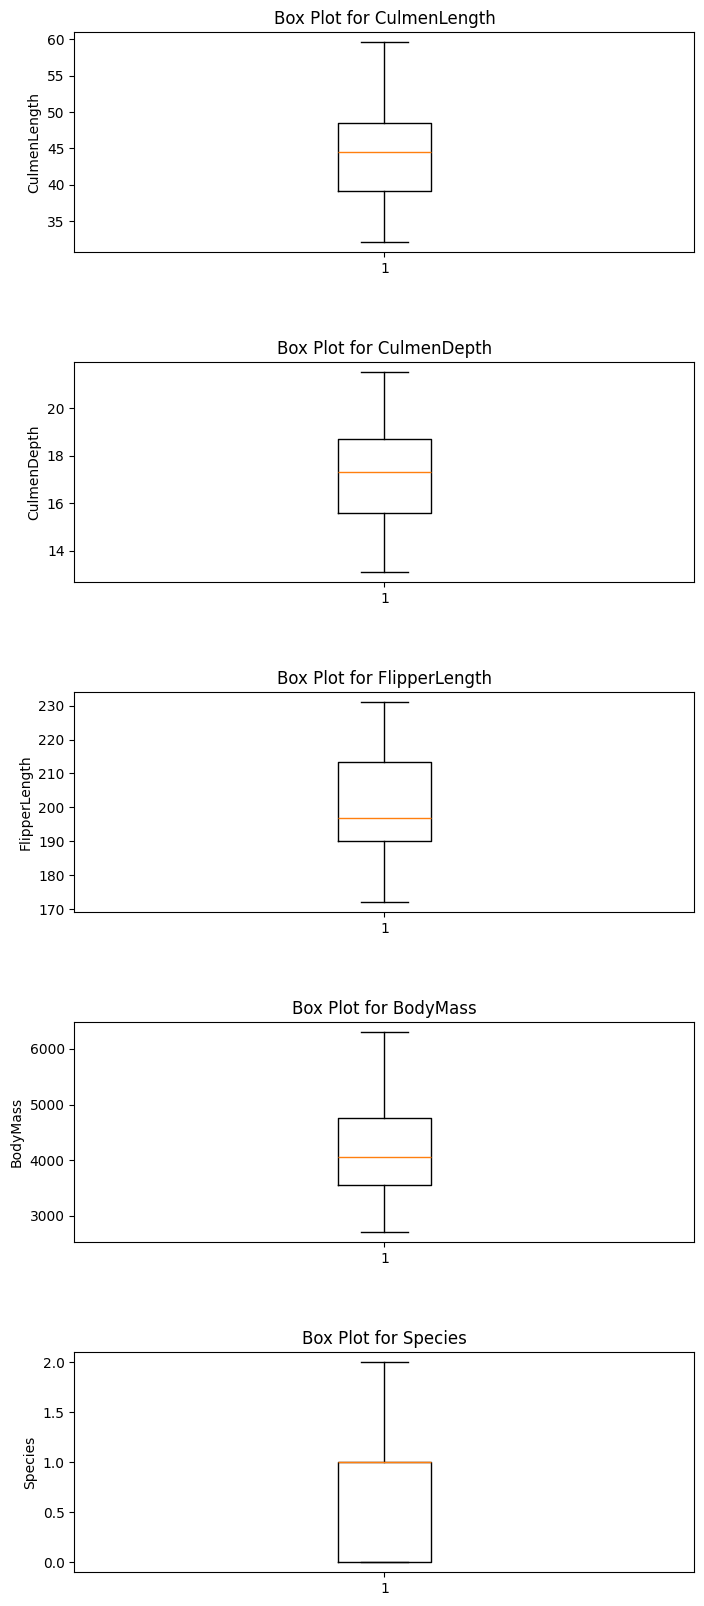

In [9]:
# Create subplots for each column
fig, axes = plt.subplots(nrows=len(columns_selection), ncols=1, figsize=(8, 4 * len(columns_selection)))
fig.subplots_adjust(hspace=0.5)

# Loop through each selected column
for i, column in enumerate(columns_selection):
    # Draw box plot
    axes[i].boxplot(df[column])
    axes[i].set_title(f'Box Plot for {column}')
    axes[i].set_ylabel(column)

# Show the box plots and outliers
plt.show()

### Histograms

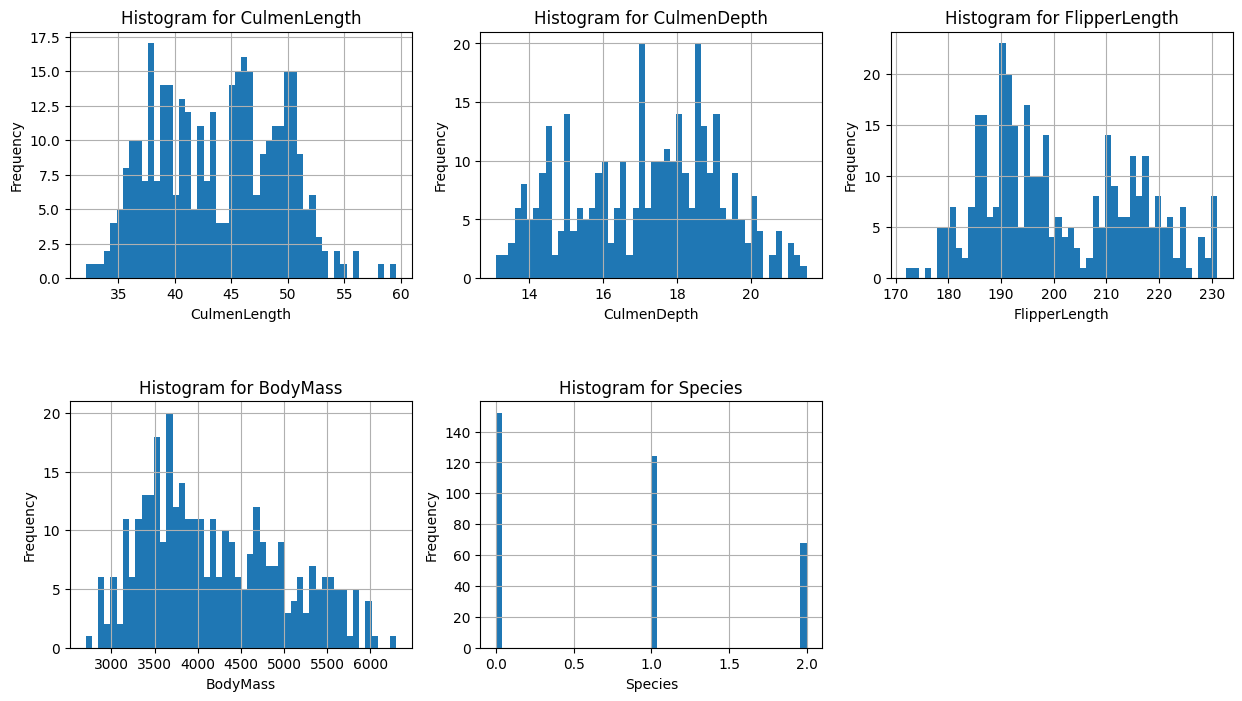

In [10]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = math.ceil(len(columns_selection) / num_columns)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 4 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Loop through each selected column
for i, column in enumerate(columns_selection):
    row_num = i // num_columns
    col_num = i % num_columns

    # Plot histogram with bins=50
    df[column].hist(bins=50, ax=axes[row_num, col_num])
    axes[row_num, col_num].set_title(f'Histogram for {column}')
    axes[row_num, col_num].set_xlabel(column)
    axes[row_num, col_num].set_ylabel('Frequency')

# Remove any empty subplots
for i in range(len(columns_selection), num_rows * num_columns):
    fig.delaxes(axes.flatten()[i])

# Show the histograms
plt.show()

### Correlation Matrix

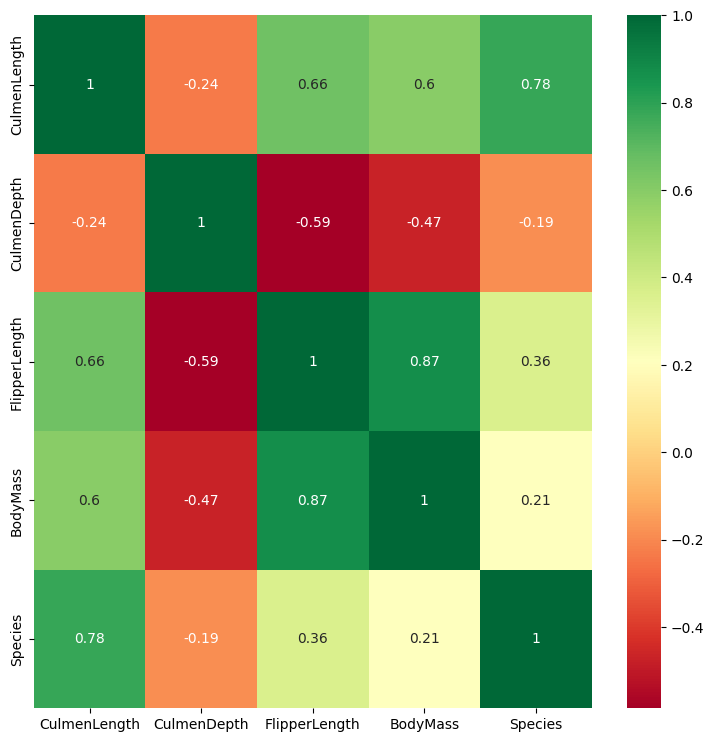

In [11]:
# calculate correlation matrix
corrmat = df.corr()

# select column names for plotting
top_corr_features = corrmat.index

# plot heat map
plt.figure(figsize=(9, 9))
g = sns.heatmap(corrmat[top_corr_features].loc[top_corr_features], annot=True, cmap="RdYlGn")
plt.show()

We can see that the Species types are highly correlated with the CulmenLength (0.78).

## 1.5 Feature Scaling
No outliers here therefore I'll be using MinMaxScaler

In [12]:
# Select columns to normalize (excluding 'Species')
columns_to_scale = df.columns[:-1]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the Data
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,0.254545,0.666667,0.152542,0.291667,0
1,0.269091,0.511905,0.237288,0.305556,0
2,0.298182,0.583333,0.389831,0.152778,0
3,0.243323,0.624566,0.304299,0.277962,0
4,0.167273,0.738095,0.355932,0.208333,0


# 2 Modeling
## 2.1 Data Splitting

In [13]:
# Assuming df is your DataFrame
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42, stratify=y)

## 2.2 Model Selection

In [14]:
def evaluate_models(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    """  
    Evaluate different classification models and compare their performance.

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Testing features.
    y_test (array-like): Testing labels.

    Returns:
    pd.DataFrame: A DataFrame containing model names, training and testing performance metrics, and standard deviations.
    """

    # Initialize models
    models = [
        ('Logistic Regression', LogisticRegression()),
        ('Decision Tree', DecisionTreeClassifier()),
        ('Random Forest', RandomForestClassifier()),
        ('XGBoost', XGBClassifier()),
        ('SVM', SVC(probability=True))  # Ensure SVC returns probabilities
    ]

    # Initialize result DataFrame
    result = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

    # Plot ROC for all models
    plt.figure(figsize=(10, 8))
    for model_name, model in models:
        # Cross-validation
        kfold = StratifiedKFold(n_splits=5)
        cross_val_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

        # Train the model with class weights
        model.fit(X_train, y_train)
        
        # Test the model
        predictions   = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, predictions)
        precision     = precision_score(y_test, predictions, average='weighted', zero_division=0)
        recall        = recall_score(y_test, predictions, average='weighted')
        f1            = f1_score(y_test, predictions, average='weighted')
        
        # Calculate ROC-AUC for multiclass classification
        prob_pos = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, prob_pos, average='weighted', multi_class='ovr')
        
        # Store results
        result.loc[len(result)] = [model_name, cross_val_result.mean(), test_accuracy, precision, recall, f1, roc_auc]

    return result

evaluate_models(X_train, y_train, X_test, y_test)

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Logistic Regression,0.965008,0.976744,0.977907,0.976744,0.976316,0.999516
1,Decision Tree,0.969080,0.953488,0.953857,0.953488,0.953091,0.964155
2,Random Forest,0.988386,0.976744,0.976744,0.976744,0.976744,0.998862
3,XGBoost,0.984465,0.976744,0.976744,0.976744,0.976744,0.998915
4,SVM,0.988311,0.976744,0.976744,0.976744,0.976744,0.999758


<Figure size 1000x800 with 0 Axes>

SVM it is!

## 2.3 Model Tuning (SVM)

In [15]:
svm_model = SVC(probability=True)

# Fine-tuning parameters
param_grid = {'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
              'degree': [1, 2, 3, 4, 5, 6],  # degree
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}  # Kernel type

# Initialize Stratified K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train,y_train)

# Access the best estimator directly
best_estimator_params = grid_search.best_estimator_.get_params()
best_estimator_params

Fitting 5 folds for each of 120 candidates, totalling 600 fits


{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [16]:
# Now you can create a new RandomForestClassifier using the best parameters
best_svm_model = SVC(probability=True)
best_svm_model.set_params(**best_estimator_params)
best_svm_model.fit(X_train,y_train)

# Training set
kfold = StratifiedKFold(n_splits=5)
cross_val_result = cross_val_score(best_svm_model, X_train, y_train, cv=kfold, scoring='accuracy').mean()

# Test the model
predictions   = best_svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
precision     = precision_score(y_test, predictions, average='weighted', zero_division=0)
recall        = recall_score(y_test, predictions, average='weighted')
f1            = f1_score(y_test, predictions, average='weighted')
        
# Calculate ROC-AUC for multiclass classification
prob_pos = best_svm_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, prob_pos, average='weighted', multi_class='ovr')


print(f"Train Accuracy: {cross_val_result:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Train Accuracy: 0.9922
Test Accuracy: 0.9884
Precision: 0.9887
Recall: 0.9884
F1 score: 0.9883
AUC-ROC: 0.9998


In [17]:
# Whole set
predictions = best_svm_model.predict(X)
accuracy    = accuracy_score(y, predictions)
precision   = precision_score(y, predictions, average='weighted', zero_division=0)
recall      = recall_score(y, predictions, average='weighted')
f1          = f1_score(y, predictions, average='weighted')

# Calculate ROC-AUC for multiclass classification
prob_pos = best_svm_model.predict_proba(X)
roc_auc = roc_auc_score(y, prob_pos, average='weighted', multi_class='ovr')

df['predicted_species'] = predictions

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.9971
Precision: 0.9971
Recall: 0.9971
F1 score: 0.9971
AUC-ROC: 1.0000


In [18]:
df[["Species", "predicted_species"]].iloc[:50]

,Species,predicted_species
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [19]:
df[["Species", "predicted_species"]].iloc[154:200]

,Species,predicted_species
154,1,1
155,1,1
156,1,1
157,1,1
158,1,1
159,1,1
160,1,1
161,1,1
162,1,1
163,1,1


In [20]:
df[["Species", "predicted_species"]].iloc[278:300]

,Species,predicted_species
278,2,2
279,2,2
280,2,2
281,2,2
282,2,2
283,2,2
284,2,0
285,2,2
286,2,2
287,2,2


In [21]:
df[df["Species"] != df["predicted_species"]].iloc[:50]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species,predicted_species
284,0.505455,0.690476,0.389831,0.402778,2,0


Only 1 missed not too shabby.
# 3 Feature Importance:

Text(0.5, 0, 'Permutation Importance')

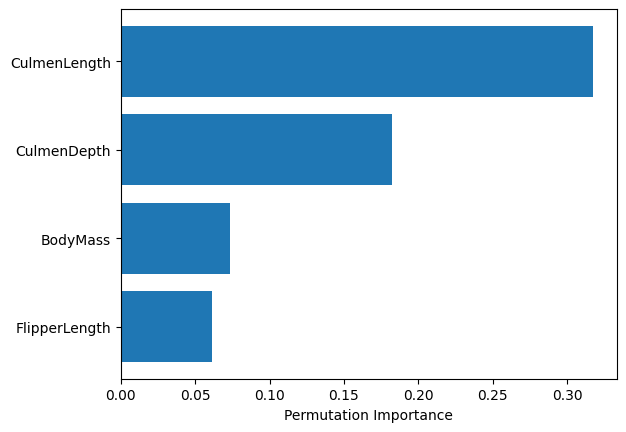

In [22]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_svm_model, X, df["predicted_species"])

features = np.array(X.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# 4 Species Characteristics Analysis

In [23]:
inverse_scaled_data = scaler.inverse_transform(df[columns_to_scale])

# Convert the NumPy array to a DataFrame
inverse_scaled_df = pd.DataFrame(inverse_scaled_data, columns=columns_to_scale)

# Update columns with inverse scaled values
df[columns_to_scale] = inverse_scaled_data

# Group by 'Species' column and calculate min and max for each group
grouped = df.groupby('Species').agg(['min', 'max'])

print(grouped[columns_to_scale])

        CulmenLength       CulmenDepth       FlipperLength        BodyMass  \
                 min   max         min   max           min    max      min   
Species                                                                      
0               32.1  46.0        15.5  21.5         172.0  210.0   2850.0   
1               40.9  59.6        13.1  17.3         203.0  231.0   3950.0   
2               40.9  58.0        16.4  20.8         178.0  212.0   2700.0   

                 
            max  
Species          
0        4775.0  
1        6300.0  
2        4800.0  


The analysis indicates the distinguishing characteristics for each penguin species as follows:
* Species 0: CulmenLength (32.1 - 46) mm ; CulmenDepth (15.5 - 21.5) mm ; FlipperLength (172 - 210) mm ; BodyMass (2850 - 4775) g.
* Species 1: CulmenLength (40.9 - 59.6) mm ; CulmenDepth (13.1 - 17.3) mm ; FlipperLength (203 - 231) mm ; BodyMass (3950 - 6300) g.
* Species 2: CulmenLength (40.9 - 58) mm ; CulmenDepth (16.4 - 20.8) mm ; FlipperLength (178 - 212) mm ; BodyMass (2700 - 4800) g.

As shown earlier, Culmen Length serves as the primary factor in determining the species to which a penguin belongs.